## Table of Contents:
* [Introduction](#introduction)
* [Data Reading and Preparation](#Prep)
* [Text Cleaning](#clean)
* [Metrics for Book Quality](#pop) 
* [Text vectorization](#vec) 
* [Singular Value Decomposition](#SVD)
* [Linear Regression](#regression)
* [Trope Identification](#TropeID)
* [Application of Neural Networks](#NN)
* [Application of Ensemble Models](#RF)
* [Conclusion](#conclusion)

<a name="introduction"></a>
## Introduction 


The goal of this project is to use the summaries of books in order to predict their popularity. The book industry relies on enticing summaries and particular themes with mass appeal, these are typically evaluated and formed by publishers editor. However, measuring and predicting these themes and their value into a summary with some degree of mathematical rigor is rare. To accomplish this report demonstrates forming an analytical pipeline including NLP vectorization using Term-Frequency-Inverse Document Frequency, and then the use of different supervised models to fit and predict the data. The objectives for this report then break down to three conceptual steps;
    1. Clean and vectorize the data
    2. Identify patterns or "tropes"
    3. Use those patterns to predict the rating 
    
    
__________________________________________________________________________________________________________
The supervised models are two different forms of regression, ridge and lasso, which each are applied. 
Vectorizing the book descriptions was relatively doable. The text had to be filtered for usable results, and the data had to be shaved down for the efficiency of the model. The use of this data in models that can accurately predict ratings is far more difficult. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import spacy
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix

import string
import re

!python -m spacy download en
%matplotlib inline

Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
symbolic link created for C:\Users\Ebel\Anaconda3\lib\site-packages\spacy\data\en <<===>> C:\Users\Ebel\Anaconda3\lib\site-packages\en_core_web_sm
Linking successful
C:\Users\Ebel\Anaconda3\lib\site-packages\en_core_web_sm -->
C:\Users\Ebel\Anaconda3\lib\site-packages\spacy\data\en
You can now load the model via spacy.load('en')


<a name="Prep"></a>

## Data Reading and Preparation 


The data were collected and hosted on Kaggle [here](https://www.kaggle.com/meetnaren/goodreads-best-books). It has a notable bias, in that it is taken from the ["best reads list"](https://www.goodreads.com/list/show/1.Best_Books_Ever) as voted by the goodreads community. As a result, virtually all the books listed are somewhat prominent, and have middling to high ratings. 

In [2]:

df = pd.read_csv(r"location\book_data.csv")
df.head()


,book_authors,book_desc,book_edition,book_format,book_isbn,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,image_url
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,9.78044E+12,374 pages,4.33,5519135,160706,The Hunger Games,Young Adult|Fiction|Science Fiction|Dystopia|F...,https://images.gr-assets.com/books/1447303603l...
1,J.K. Rowling|Mary GrandPré,There is a door at the end of a silent corrido...,US Edition,Paperback,9.78044E+12,870 pages,4.48,2041594,33264,Harry Potter and the Order of the Phoenix,Fantasy|Young Adult|Fiction,https://images.gr-assets.com/books/1255614970l...
2,Harper Lee,The unforgettable novel of a childhood in a sl...,50th Anniversary,Paperback,9.78006E+12,324 pages,4.27,3745197,79450,To Kill a Mockingbird,Classics|Fiction|Historical|Historical Fiction...,https://images.gr-assets.com/books/1361975680l...
3,Jane Austen|Anna Quindlen|Mrs. Oliphant|George...,«È cosa ormai risaputa che a uno scapolo in po...,"Modern Library Classics, USA / CAN",Paperback,9.78068E+12,279 pages,4.25,2453620,54322,Pride and Prejudice,Classics|Fiction|Romance,https://images.gr-assets.com/books/1320399351l...
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,9.78032E+12,498 pages,3.58,4281268,97991,Twilight,Young Adult|Fantasy|Romance|Paranormal|Vampire...,https://images.gr-assets.com/books/1361039443l...


In [3]:
print(df.shape)

(54301, 12)


This is a massive set of data with relatively few features, and fewer of those features immediately usable to the pipeline. Book Edition, Book Format, Book ISBN, Book Authors, Book Title, and image_url are all either useless or out of scope as something that would not be considered to be apart of how a book is structured or summarized. Most of these features will either be reworked or dropped as the data are prepped for analysis. 

The data have no limitation on language on genre or format for the books. This ties into the obvious first issue with this particular data set, it's massive size. While analyzing the full dataframe would allow for a more robust and versatile model, it is also really computationally intensive with many NLP models. It is possible to subset the data arbitrarily, but, it's possible to subset by genre, and train the model in a specific environment. Patterns and tropes will be easier to isolate and fit within a dataset dedicated to a particular genre for analysis.

The way that genres are defined here is rather messy, so the string will be broken down into constituent parts, and a primary genres will be identified using the most popular genre tag, which will then define the genre of that book. This allows genres to be simplified and picked apart easier than with the list provided by the dataset. 

In [4]:

book_genres = [str(genre).split("|") for genre in df['genres']]
genres = set([genre for book in book_genres for genre in book])
count = []
for genre in genres:
    count.append([sum([genre in str(g) for g in df['genres']]), genre])
sorted(count, reverse = True)   

[[30959, 'Fiction'],
 [14392, 'Fantasy'],
 [13366, 'Adult'],
 [13207, 'Roman'],
 [12910, 'Romance'],
 [10533, 'Young Adult'],
 [7727, 'Nonfiction'],
 [7187, 'Historical'],
 [6673, 'Literature'],
 [6662, 'Science'],
 [6474, 'Contemporary'],
 [6409, 'Historical Fiction'],
 [6319, 'Class'],
 [6317, 'Classics'],
 [5727, 'Mystery'],
 [5588, 'Science Fiction'],
 [5227, 'Paranormal'],
 [4975, 'Cultural'],
 [4018, 'Novels'],
 [3966, 'Childrens'],
 [3347, 'nan'],
 [3114, 'Thriller'],
 [2974, 'History'],
 [2954, 'European Literature'],
 [2406, 'Biography'],
 [2316, 'Horror'],
 [2269, 'Adventure'],
 [2251, 'Art'],
 [2151, 'Humor'],
 [2115, 'Contemporary Romance'],
 [2080, 'Crime'],
 [1960, 'Christian'],
 [1940, 'Philosophy'],
 [1847, 'Short Stories'],
 [1817, 'Religion'],
 [1810, 'Magic'],
 [1763, 'Autobiography'],
 [1761, 'Womens'],
 [1751, 'Memoir'],
 [1731, 'War'],
 [1726, 'Sequential Art'],
 [1709, 'Paranormal Romance'],
 [1695, 'Vampires'],
 [1649, 'Womens Fiction'],
 [1641, 'Chick Lit'],
 [

Predictably, the most popular genre tag is "Fiction" a very broad category, which has twice the listings of any other category. It by far has the largest number of listing than anything afterward. It is worth noting that these are not exclusive categories. Most mystery books would include the "fiction" tag, and thus also be counted within this system. 

Any array of genres can be selected below for the model to train on. Across multiple iterations of this selection process and it's use in the models below found that the models perform better with similar genres paired together, like the choice here for "Adventure" and "Fantasy." As opposed to "Science Fiction" and "Historical." Notably, the Single Vector Decomposition is able to capture more variance with less varied genres, which results in less computationally intense models working with better selected data. SVD picks up on redundant features, picking apart patterns and trends in the data that are heavily correlated. Within similar genres, more clear and homogeneous patterns emerge that are easier for the SVD to decompose. In example, the word "ship" often has a different meaning depending on whether it's in a Science Fiction or Fantasy novel. 

The more genres picked, obviously increases the size and variance of the resulting Dataframe, which can increase the amount of data the model has to train and test on, but also the computational cost of the models. The resources, time, and accuracy all should be assessed by a user in this instance in order to make the best compromise possible for their particular need of this model. 

The genres bellow were picked to produce a reasonably sized dataframe with similarish themes. There's still plenty of variance, but the resulting dataframe is reasonable in terms of computational cost of processing. 

In [5]:
genres= ["Science Fiction", 'Mystery', 'Paranormal', 'Adventure']
df = df.loc[[any([subject in genres for subject in book]) for book in book_genres]]
df.loc[:, 'genres'] = df['genres'].apply(lambda x: [sub for genre in str(x).split("|") for sub in genres if sub == genre]).values
df.shape

(16387, 12)

In [6]:
df.iloc[1]

book_authors                                           Stephenie Meyer
book_desc            About three things I was absolutely positive.F...
book_edition                                                       NaN
book_format                                                  Paperback
book_isbn                                                  9.78032E+12
book_pages                                                   498 pages
book_rating                                                       3.58
book_rating_count                                              4281268
book_review_count                                                97991
book_title                                                    Twilight
genres                                        [Paranormal, Paranormal]
image_url            https://images.gr-assets.com/books/1361039443l...
Name: 4, dtype: object

Book ISBN and imageurl are meaningless features that can only interfer with how a model fits.  They have no meaning in terms of the books themes or summary. To improve the efficiency and limit the scope of the model it's being dropped here. 

In [7]:
df = df.drop(['book_isbn', 'image_url'], axis=1)


In [8]:
df.head()

,book_authors,book_desc,book_edition,book_format,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,374 pages,4.33,5519135,160706,The Hunger Games,"[Science Fiction, Science Fiction]"
4,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,498 pages,3.58,4281268,97991,Twilight,"[Paranormal, Paranormal]"
7,George Orwell,مزرعة الحيوانات هي رائعة جورج أورويل الخالدة.....,NaN,Paperback,122 pages,3.90,2235084,42156,Animal Farm,"[Science Fiction, Science Fiction]"
11,Douglas Adams,Seconds before the Earth is demolished to make...,NaN,Paperback,193 pages,4.21,1155911,23919,The Hitchhiker's Guide to the Galaxy,[Science Fiction]
14,Dan Brown,An ingenious code hidden in the works of Leona...,NaN,Paperback,481 pages,3.81,1668594,43699,The Da Vinci Code,[Mystery]


Book pages as it's provided is an object that doesn't give much to any model. The following code turns it into an integer that can be used in models further on. 

In [9]:
#The following code runs cleaner with a normal index
df.reset_index(inplace= True, drop=True)

[int(s) for s in df.loc[1, 'book_pages'].split() if s.isdigit()]

int(re.sub(r" pages","",df.loc[1, 'book_pages']))

498

In [10]:
#some entries were not strings, dropping the NaN results of those objects here. 
df = df.dropna(subset=['book_pages'])

In [11]:
df['book_pages'] = df['book_pages'].apply(lambda x : int(re.sub(r" pages*","",x)))

In [12]:
df.head()

,book_authors,book_desc,book_edition,book_format,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,374,4.33,5519135,160706,The Hunger Games,"[Science Fiction, Science Fiction]"
1,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,498,3.58,4281268,97991,Twilight,"[Paranormal, Paranormal]"
2,George Orwell,مزرعة الحيوانات هي رائعة جورج أورويل الخالدة.....,NaN,Paperback,122,3.90,2235084,42156,Animal Farm,"[Science Fiction, Science Fiction]"
3,Douglas Adams,Seconds before the Earth is demolished to make...,NaN,Paperback,193,4.21,1155911,23919,The Hitchhiker's Guide to the Galaxy,[Science Fiction]
4,Dan Brown,An ingenious code hidden in the works of Leona...,NaN,Paperback,481,3.81,1668594,43699,The Da Vinci Code,[Mystery]


<a class="anchor" id="clean"></a>
## Text Cleaning
Text is rarely easy for a computer to understand. One of the reasons for this is the need to transform the text into a numerical form that can be processed by our models, vectorization. The other part of it is the inherent chaos of human language. Every word can have dozens of variations and deviations which have identical meaning, but different spelling. Errors, accents, eccentricities, all of these make the data harder to represent in a coherent mathematic way in a way valuable to a model. For this reason, it's standard practice to move through the text and standardize it with a variety of functions. 

The summaries listed here were not immediately amenable to analysis. Language introduces extreme and unnecessary variability within the dataset. There are many different languages to express a particular word, but it's meaning can better be understood as a single feature. For this reason a mono-linguistic dataset will produce a more coherent dataframe with fewer meaningless redundancies. Within this data many non-English translations aren't easy to parse, and do more to interfere with a model then train it. While this same framework can be adapted for other languages, as it does not use Spacy, this pipeline is built to use English. A prime example of this would be the contraction map below used to expand out specifically English contractions. 


In [14]:
# This is to evaluate the number of null values within our chosen values, and ensure we aren't losing too much.

df['book_desc'].isnull().sum()

72

In [15]:
# Only dropping null values in relevant vector generators. 
df = df.dropna(subset=['book_desc', 'book_title'])

df['book_desc'].isnull().sum()

0

Contractions cause issues with filtering out common stop words, and removing them can help removing small variations between words and combining variations of words identical in meaning into the same feature. 


The contraction map used below can be found [here.](https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/bonus%20content/nlp%20proven%20approach/contractions.py)


In [16]:


CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all can't expand contractions I'd think")


'You all cannot expand contractions I would think'

Aside from the language issue, there's the issue with non standard text that throws a wrench in to the average NLP process, in which standard methods were employed to remove it from the dataframe. Text which is apart of a books format, such as symbols or questions marks, or text that's two words combined together into a single character, these all generate issues that we bypass by reading the text visually, but need to be addressed for a computer vectorizing it. 

In [17]:
def text_cleaner(text, author=''):
    #Removes everything problematic from a text. 
    text = re.sub(r'--',' ',text)
    text = re.sub(r'[—–―]',"-",text)
    
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    
    text = re.sub(r'[’‘]',"'",text)
    text = re.sub(r'[”“]','"',text)
   
    text = re.sub(r'ﬁ',"fi",text)
    text = re.sub(r'r',"r",text)
    text = re.sub(r'i',"i",text)
    text = re.sub(r'n',"n",text)
    text = re.sub(r'ﬂ',"fl",text)
    
    text = re.sub(r'[�©✔€™£]',"",text)
    text = re.sub(r'…',"...", text)
    text = re.sub(r'\ufeff',"",text)
    text = re.sub(r'\x97',"",text)
    text = re.sub(r'\(back cover\)',"",text)
    text = re.sub(r'(.)\1{2,}',"\\1\\1",text)
    text = re.sub(author, "", text)
    text = expand_contractions(text)
    
    text = re.sub(r' +'," ",text)
    
    return text
 

    

Non-English, while a valid subject for other analysis, but it's simpler to process one language and english is better studied and thus easier to parse. This can help filter it out non-English to properly vectorize and analyze the text. An analytical pipeline for other languages could be structured similarly with different modules for precessing. 

It is possible to let all the languages into the dataframe, and that english might dominate, but there's a large number of duplicate entries under different languages. A mono-linguistic set will remove these concerns entirely. 

This function is to detect non-english words, and will be used to filter out everything else, but it can be modified easily for other languages. 

In [18]:
from langdetect import detect
def isEnglish(s):
    
    lang = detect(s)
           
    return lang == 'en'

In [19]:
#Give the cleaner a quick test to make sure it did what was intended. 
text_cleaner(df.loc[1,'book_desc'])

'About three things I was absolutely positive.First, Edward was a vampire.Second, there was a part of him-and I did not know how dominant that part might be-that thirsted for my blood.And third, I was unconditionally and irrevocably in love with him.In the first book of the Twilight Saga, internationally bestselling author Stephenie Meyer introduces Bella Swan and Edward Cullen, a pair of star-crossed lovers whose forbidden relationship ripens against the backdrop of small-town suspicion and a mysterious coven of vampires. This is a love story with bite.'

This function is useful, but some of the entries are not strings, or lack actual text to apply these functions too. 

In [20]:
df['book_desc'] = df['book_desc'].astype(str)

C:\Users\Ebel\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
#This code limits the dataframe to instances in which book descriptions exceed 3 characters. 
df = df[df['book_desc'].map(len) > 3]

This for loop serves two purposes, it first detects any non english entries and marks them for removal, then it applies the text cleaner to the english entries that will remain in the dataframe. 

In [22]:
#Rows have been dropped, so reseting the index allows the for loop to run correctly 
df.reset_index(drop=True, inplace=True)
clean = []
rm_idx = []
print('Non-english books:\n')
for book_id in df.index.values: 
    book = df.loc[book_id, 'book_desc']
    if isEnglish(book):
        book = text_cleaner(book)
        clean.append(book)
        rm_idx.append(True)
    else:
        print(book_id, book[:60])
        rm_idx.append(False)

Non-english books:

2 مزرعة الحيوانات هي رائعة جورج أورويل الخالدة.. اختيرت دائمًا
13 Fahrenheit 451 ofrece la historia de un sombrío y horroroso 
136 Un abogado, Gabriel John Utterson, investiga la extraña rela
270 'Opal' is het derde deel in de Lux-serie van Jennifer L. Arm
387 Toronto, 1843: Das junge Dienstmädchen Grace wird mit sechze
418 Glen Runciter está muerto. ¿O lo están todos los demás? Lo q
485 Contacto es la única novela escrita por el astrónomo estadou
570 Gwendolyn ist am Boden zerstört. War Gideons Liebesgeständni
665 Frisch verliebt in die Vergangenheit, das ist vielleicht kei
721 Quince años mas tarde, la memoria de aquel dia ha vuelto a m
910 Es ist das Jahr 2033. Nach einem verheerenden Krieg liegen w
1155 À New York, au printemps 2008, alors que l’Amérique bruisse 
1194 Geheimnisvolle Türen mit Eidechsenknäufen, sprechende Steinf
1297 Le jour de la naissance de Jack, en 1874 à Edimbourg, est si
1425 Torcuato Luca de Tena, periodista y escritor de gran prestig
1462

4920 1984 é uma das obras mais influentes do século XX, um inques
4958 Když se Will stal členem hraničářského sboru, složil slavnos
4986 Complete Conan of CimmeriaMit einem Vorw. von Wolfgang Hohlb
4995 პოლონელი მწერლის, მეცნიერისა და ფილოსოფოსის, სტანისლავ ლემის
4996 Horác by se coby vyslanec v cizí zemi neměl vměšovat do vnit
5007 Amb el títol de "Mecanoscrit del segon origen" és conegut, l
5026 Una extraña enfermedad que ha dejado a su hermano en estado 
5035 İngiliz yazar George Orwell (1903-1950), ülkemizde daha çok 
5070 Cat timp exista tinuturi necunoscute, oameni inca neintalnit
5072 Midge und Mike, zwei junge Künstler, haben ein romantisches 
5077 " Trafalgar " (1873) es el primero de los " Episodios nacion
5099 (Description from the back of the book)Første bok i SAGAEN O
5167 Un misterioso fabricante de juguetes que vive recluido en un
5188 «Посёлок» — одно из самых сильных произведений К.Булычёва. Э
5191 SİLAHŞÖR GİZEMLİ YOLCULUĞUNA BAŞLIYOR.KARA KULE NEREDE?ONU B
5257 "Some

6749 Tess tem um segredo que a afasta dos comuns adolescentes. É 
6763 La tinta está en su sangre y con el amor, cobra vida.Después
6764 'Mrs. Fontaine, excuses dat ik nog zo laat bel, maar...'Sara
6768 Die hoffnungslos naive Nao landet urplötzlich mitten in eine
6779 Nome: Jordan MarsalisStatura: 1,86Occhi: AzzurriCapelli: Sal
6784 New Hampshire, sommaren 1975. En ung kvinna vid namn Nola Ke
6786 1987. Op het strand van Nordkoster wordt bij vollemaan een g
6793 Światy równoległe, genialny wynalazek, pełna przygód niezwyk
6794 La storia è costruita intorno a tre poliziotti, Bud White, J
6798 Cuando el detective Aidan Reagan registra la casa de una muj
6802 Alice Gould es ingresada en un sanatorio mental. En su delir
6806 Önce Onlara güvenilmeyeceğini kanıtladılar. Sonra Birbirimiz
6808 И в първата, и във втората книга на дилогията авторът ни пре
6820 A fiatal Darrow a Marson él, bányász, és Vörösnek született,
6825 Una saga esplendidamente escrita de enanos y elfos, duendes 
6832 Üç şe

7507 Imagine uma época em que os livros configurem uma ameaça ao 
7509 Jeden Morgen pendelt Rachel mit dem Zug in die Stadt, und je
7510 Il romanzo è ambientato in un mondo devastato da un'epidemia
7511 Een ontsnapte kindermoordenaar terroriseert een klein stadje
7524 영국 작가의 세계적인 장편소설. 인간에게 착취 당하던 동물들이 인간을 내쫓고 동물농장을 세운다는 큰 줄거리 
7543 1984. Il mondo è diviso in tre immensi superstrati in perenn
7546 Em O Meu Nome É Vermelho, inicia-se uma viagem até Istambul,
7552 Im Jahr 2018 hat Luzifer die Zahl der Dämonen in allen größe
7556 Pierwsze w Polsce wydanie opowiadań grozy i fantastyki H.P. 
7557 Praca w służbach specjalnych niektórych może pociągać, innyc
7558 En verdad os digo que se acerca el tiempo de la espada y el 
7564 Linnet Ridgeway é uma jovem que tem tudo: beleza, riqueza, a
7571 Barcelona, 1945. El pequeño Daniel Sempere llega a El cement
7573 În lumea magică a Londrei Victoriene, Tessa Gray şi-a şăsit 
7587 Kurt Wallander atraviesa uno de los momentos más sombríos de
7588 ROSSU

8412 Nová kniha Jiřího Kulhánka je pochmurný příběh z pochmurné b
8424 Bēgot no nepielūdzamās armijas, Tods ir atnesis nāvīgi ievai
8432 Vanavond heb ik een grens overschreden, en als vader gelijk 
8440 Ne definim prin amintirile noastre. Dar dacă ne-am trezi bru
8452 ¿Está bien odiar a un chico muerto?¿Incluso si alguna vez lo
8461 Europa 1877: Die Macht der letzten großen Vampir-Clans ist a
8465 Açlıktan ölmek üzereydim. Ama yine de yiyecek bir şey uzatma
8472 Hi, ich bin Evie und eigentlich total normal. Dachte ich zum
8474 En el siglo XXV, la humanidad ha alcanzado la inmortalidad g
8482 Los Angeles, anni Cinquanta. Tre personaggi diabolici voglio
8486 Cerrah bizimle konuşuyor. Ve bu tedirgin edici sohbetten kan
8487 Una apasionante intriga judicial llena de trampas y de giros
8492 Tras el largo verano, el invierno se acerca a los Siete Rein
8494 Gizemli Bir AdaTerk edilmiş Bir YetimhaneTuhaf Fotoğraflar16
8507 Egy test, két lélek és minden idők legizgalmasabb szerelmi h
8508 Histo

9071 A Barcellona una mattina d'estate del 1945 il proprietario d
9073 ZEVK, GÜNAHIN TUZAĞIDIR…On altı yaşındaki, lise öğrencisi An
9076 Kuzey" in soğuk ormanlarında yaşam kavgası... Açlık ve hayat
9080 این کتاب بیانیهٔ سیاسی شاخصی در رد نظام‌های تمامیت‌خواه (توت
9081 Esta novela nos cuenta la vida de Buck, un perro, mezcla de 
9083 Sétimo livro da série Outlander, Ecos do Futuro vai além da 
9089 A la fois symbole de la rébellion et marionnette d'une dicta
9117 GROMOWŁADNY to egzotyczna powieść w stylu Borgesa, która naw
9139 Confine russo polacco intorno agli anni 1926-30. Un interreg
9141 Grangé'nin uzun zamandır beklenen romanı...Soluğunuzu kesen 
9166 Rungard Valdorian, Primus inter Pares des größten Wirtschaft
9175 Nostradamus escreveu milhares de profecias.Apenas 942 chegar
9176 «Прозрачные витражи» — фантастическая повесть Сергея Лукьяне
9194 Akhirnya Conan (alias Shinichi) berani mengungkapkan perasaa
9200 Nathan en Julia zitten bij elkaar in de klas. Ze zijn niet e
9208 ছোটবে

9960 Adım Ruby.Hepinizden farklıyım.Aklınızın derinliklerinde gez
9962 Watson mène l'enquête, suite à la mort de Sherlock Holmes, c
9963 Hercule Poirot semble enfin avoir trouvé des adversaires à s
9965 Algernon est une souris de laboratoire, Charlie Gordon un si
9975 Mit sechzehn beginnt eine magische Zeit sagt man. Es warten 
9977 A humanidade vive o seu momento mais próspero. Há mais de de
9978 Neste terceiro e último volume da série, Lisbeth Salander se
9979 
MEMORIZA. CORRE. SOBREVIVE.
«Bienvenido al bosque. Verá
9980 Jefferson Winter no es un investigador corriente. Tiene una 
10026 რომანი / [თარგმ. რუსუდან ქებულაძისა. - 1-ლი გამოც.]რომანში ა
10027 Getrennt durch zwei Welten, geeint im Überlebenskampf, verbu
10031 Edmundo Dantés es un marino joven y exitoso, enamorado de Me
10035 Jamie e Claire, naufragati sulle coste delle Colonie America
10051 Eigentlich sollte sich Kommissar Matthai, der auf der Höhe s
10056 ...В этом мире солнце желто, как глаз дракона - огнедышащего
10073 In

10924 Ameninţaţi de haosul unui război, vânătorii de umbre trebuie
10932 Cat è figlia di un angelo, e ha fatto un giuramento. Scoprir
10948 Tuhansien vuosien takaa alkanut fantastinen aikamatka jatkuu
10957 (notka z tylnej okładki)Potrzebujesz tony humoru, funta zaga
10977 Nieuwe thriller van de auteur van de bestseller Rendez-vous.
10986 Die 16-jährige Neva hat es satt, keine Antworten auf Fragen 
10997 নেলী খালার চিঠি পেয়ে বাবুকে নিয়ে নুলিয়াছড়িতে নেলী খালার নতুন
11027 Un pirata informático que se infiltra en el Vaticano. Una ig
11054 Lady Aileana non ha paura della notte: è nelle pieghe del bu
11057 Strigoi, vampiri și vârcolaci din Transilvania. Ființe ale Î
11070 Millainen maailma olisi, jos John F. Kennedyä ei olisi murha
11075 Enamorarse no formaba parte de los planes de Nora Grey. Nunc
11076 La vicenda di Asimov e dei Vedovi Neri è la storia di un amo
11078 1ère Vague : Extinction des feux.2è Vague : Déferlante.3è Va
11079 Tout allait bien dans ma vie jusqu'à ce que je me transf

12158 Der knisternde Psychothriller des umjubelten Bartimäus-Stara
12162 Fuyant son nouveau petit ami violent, Christy, l'ex-femme d'
12170 Eski bir harika dedektifler geleneği vardır ve Dirk Gently k
12175 Évidemment, je m'y attendais puisque j'en suis l'auteur mais
12176 «No tengas miedo», le susurré.«Somos como una sola persona».
12185 Mundos Paralelos é uma trilogia mágica e poderosa, recheada 
12193 Le plus beau des rêves : Batir ailleurs une nouvelle humanit
12194 Philip, sans la connaître, déteste cette femme que son cousi
12195 Membrii echipajului Ares 3 ajung pe Marte pentru o misiune p
12198  Oberflächlich betrachtet sind Cora und Maja zwei ganz norma
12203 Livia valikoituu lukemattomien innokkaiden hakijoiden joukos
12212 Riva mencoba memulai menata kembali kehidupannya yang sempat
12272 De toekomst van de Zeven Koninkrijken staat op het spel – va
12279 L'inspecteur de police Dave Robicheaux de New Iberia en Loui
12296 Meg Finn morre, acidentalmente, durante o maquiavélico r

13556 Er schreibt und schreibt und wird immer besser: Der russisch
13574 «New York var en labyrint av endeløse skritt. Og uansett hvo
13580 Yirminci yüzyılın en önemli yazarlarından biri olan George O
13581 Todos os dias, em todos os países do mundo, os hospitais efe
13586 Blíží se jaro a Will s Evanlyn mohou konečně prchnout ze Ska
13587 Ein magisches Beben erschüttert die Küsten der Karibik. Und 
13627 Nachdem Moebius Mitte der 1970er im Magazin Métal Hurlant mi
13638 Will coby plnohodnotný hraničář pečující o vlastní léno se z
13651 In de eenzame moerassen valt opnieuw een geestendicht te hor
13663 First publication.Cover Artist: Hoot von Zitzewitz
13696 „კუნძულის შესაძლებლობა“ მსოფლიო ბესტსელერების – „ელემენტარულ
13697 Trez "Latimer" valójában nem létezik. Árnyékként él és dolgo
13700 Kde najde Will v rozvráceném severním lénu bojovníky, které 
13706 Ficção de estréia de um dos mais respeitados teóricos da sem
13707 Întunericul s-a pogorât asupra lumii vânătorilor de umbre. H
13715

In [23]:
print(df.shape)
df = df.loc[rm_idx]
print(df.shape)

(15771, 10)
(14544, 10)


It appears out of roughly 1600 entries, a little over a 1000 were caught and thrown out by the filter. 

Fortunately, it appears that most of the corpus was English, so there's still plenty of data to drop and select from. However, this does represent a substantial English bias in the listings, if this is to be repeated for a different language, a larger initial subset would be recommendable, to result in a 

In [24]:
df.loc[:, 'clean_text'] = clean

df

,book_authors,book_desc,book_edition,book_format,book_pages,book_rating,book_rating_count,book_review_count,book_title,genres,clean_text
0,Suzanne Collins,Winning will make you famous. Losing means cer...,NaN,Hardcover,374,4.33,5519135,160706,The Hunger Games,"[Science Fiction, Science Fiction]",Winning will make you famous. Losing means cer...
1,Stephenie Meyer,About three things I was absolutely positive.F...,NaN,Paperback,498,3.58,4281268,97991,Twilight,"[Paranormal, Paranormal]",About three things I was absolutely positive.F...
3,Douglas Adams,Seconds before the Earth is demolished to make...,NaN,Paperback,193,4.21,1155911,23919,The Hitchhiker's Guide to the Galaxy,[Science Fiction],Seconds before the Earth is demolished to make...
4,Dan Brown,An ingenious code hidden in the works of Leona...,NaN,Paperback,481,3.81,1668594,43699,The Da Vinci Code,[Mystery],An ingenious code hidden in the works of Leona...
5,Veronica Roth,"In Beatrice Prior's dystopian Chicago world, s...",NaN,Paperback,487,4.22,2493519,104329,Divergent,[Science Fiction],"In Beatrice Priors dystopian Chicago world, so..."
6,Paulo Coelho|Alan R. Clarke|Özdemir İnce,Paulo Coelho's masterpiece tells the mystical ...,NaN,Paperback,197,3.84,1644387,63861,The Alchemist,[Adventure],Paulo Coelhos masterpiece tells the mystical s...
7,Orson Scott Card,"Andrew ""Ender"" Wiggin thinks he is playing com...","Author's Definitive Edition, Revised mass mark...",Mass Market Paperback,324,4.30,965351,40289,Ender's Game,[Science Fiction],"Andrew ""Ender"" Wiggin thinks he is playing com..."
8,Cassandra Clare|Franca Fritz|Heinrich Koop|Fra...,When fifteen-year-old Clary Fray heads out to ...,NaN,Hardcover,485,4.11,1383479,55446,City of Bones,[Paranormal],When fifteen-year-old Clary Fray heads out to ...
9,Audrey Niffenegger,"A funny, often poignant tale of boy meets girl...",Special Edition,ebook,500,3.96,1408080,45153,The Time Traveler's Wife,"[Science Fiction, Science Fiction]","A funny, often poignant tale of boy meets girl..."
10,Bram Stoker|Nina Auerbach|David J. Skal,You can find an alternative cover edition for ...,Norton Critical Edition,Paperback,488,3.98,775448,19726,Dracula,[Paranormal],You can find an alternative cover edition for ...


<a name="pop"></a>
## Metrics for book quality

There's two ways of quantifying popularity of a book within the dataset, the average rating, and the number of ratings.The average rating represents how highly a reader of a book liked it, the number of ratings reflect how many people chose to rate, and thus likely read, the book. 

A book that is widely read tends to be considered to be "successful" and has quality at least at a market level. The more reviews a book has, the more likely it has been read by a large number of readers. This is the more direct approach to a publishing houses goal of publishing books that will be widely bought and read. 

Both are of interest to a publisher and author and the social underpinnings of these metrics might be worthwhile in a more thorough analysis, but simply looking for a good distribution will be for the best. 

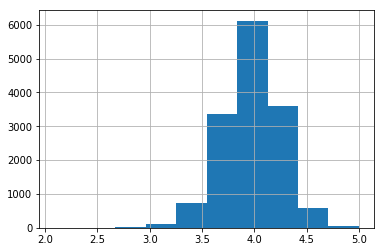

In [25]:
df['book_rating'].hist();

One of the issues brought up by the source of the scraped data, the 10000 "best books" list from goodreads, is evident in this histogram, the majority of scores are listed about 3.5 and no score fell below a 2. However, the data does appear normal. A shapiro wilks test will be used to verify that impression. 

In [26]:
from scipy.stats import shapiro

shapiro(df['book_rating'])

C:\Users\Ebel\Anaconda3\lib\site-packages\scipy\stats\morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9951950311660767, 1.7576487398016874e-21)

The data produced a test statistic near 1, and has negligble probability of being sampled from a population without a normal distribution. While the large sample size may inflate these values, it does demonstrate that it is safe to describe this data as normal. 

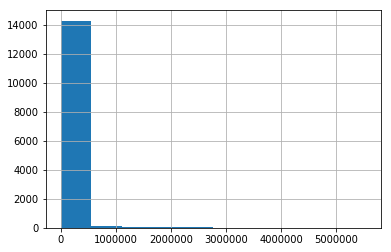

In [27]:
df['book_rating_count'].hist();

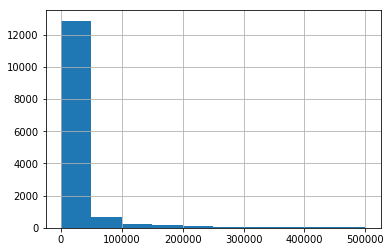

In [28]:
df['book_rating_count'].hist(range=[0, 500000]);

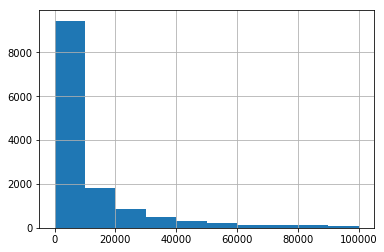

In [29]:
df['book_rating_count'].hist(range=[0, 100000]);

This distribution is skewed, a possible bias is present in terms of the amount of time that a title has time to accumulate ratings. There was no limit or control for when a book had to start it's listing, so a new novel may have had a month to accumulate the same number of ratings as an entry that has been listed since goodreads launch. 

In terms of normalcy, the ratings average is closer to a Normal distribution.  and will be used Ultimately, once the model has access to one of these, it has access to the other. Once the ratings are in, the average is readily calculable. So given that the model is using book ratings average, dropping the ratings count is necessary.

In [30]:
df = df.drop(['book_rating_count', 'book_review_count'], axis=1)

The differences in this data are very granular, and this poses a problem for regression. The standard way of measuring the accuracy of a regression, and the method used in this report, is the R squared value. For reference the equation for R squared is detailed here: 

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/0ab5cc13b206a34cc713e153b192f93b685fa875)

In which the value of $SS_{reg}$ is the explained sum of squares, or the cumulative amount that data varied from the regression, and $SS_{tot}$ is the total sum of squares, or the amount of variance in the data.

Values like these will produce a very small total sum of squares. Because of this a difference between 4.1 and 4.15 in the prediction has serious implications on the models R squared value. A human might not find the difference between such scores significant, and it's possible this issue would be reduced a more varied corpus collected from a wider array of book ratings, but this is a significant challenge for the regression, to pick apart small differences in score. 

In case the regression fails to do so in a productive way, a categorical variable can be used to get a less useful, but easier prediction from the broader categories. The obvious first category to attempt would be the nearest round number, potentially breaking the data up into 5 distinct values. 

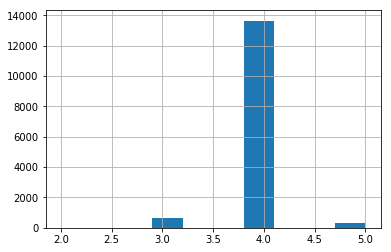

In [31]:
df['book_rating_rounded'] = round(df['book_rating'])
df['book_rating_rounded'].hist()

This is not varied enough to be useful. 4 is a massive dominant class when rounded. We'll break it down into larger parts, that can still be used in classification. 

In [32]:
df = df.drop('book_rating_rounded', axis=1)

In [33]:
df.isnull().sum()

book_authors        0
book_desc           0
book_edition    13092
book_format        88
book_pages          0
book_rating         0
book_title          0
genres              0
clean_text          0
dtype: int64

In [34]:
df.shape

(14544, 9)

Editions would be something in scope, as that is something a publisher would know or could even decide before the book was offered on sale. It's possible that people like books that are the "US edition" of foreign classics, or that multiple editions indicates a book that is likely to be popular. However it is evident that very few books in the corpus have an edition listed. That feature can be dropped. The null values in book_format are a small enough number that they can be dropped before being fed into the vectorization. 

In [35]:
train, test = train_test_split(df, test_size=0.3)
train.head()

,book_authors,book_desc,book_edition,book_format,book_pages,book_rating,book_title,genres,clean_text
7633,Amelia Atwater-Rhodes,"Zane Cobriana, cobra shapeshifter, thanks the ...",NaN,Paperback,167,3.99,Snakecharm,[Paranormal],"Zane Cobriana, cobra shapeshifter, thanks the ..."
2915,Amy A. Bartol,Eighteen-year-old Kricket Hollowell was lookin...,NaN,Kindle Edition,320,4.24,Sea of Stars,[Science Fiction],Eighteen-year-old Kricket Hollowell was lookin...
15689,Simone Beaudelaire,An alternate cover edition can be found here.P...,NaN,Kindle Edition,270,3.50,Watching Over the Watcher,[Paranormal],An alternate cover edition can be found here.P...
464,Robert Shea|Robert Anton Wilson,"It was a deadly mistake. Joseph Malik, editor ...",Trade Paperback,Paperback,805,4.00,The Illuminatus! Trilogy,[Science Fiction],"It was a deadly mistake. Joseph Malik, editor ..."
2286,Richard Paul Evans,Michael must save his mother—and protect his p...,NaN,Hardcover,335,4.30,Rise of the Elgen,"[Science Fiction, Adventure]",Michael must save his mother-and protect his p...


<a name="vec"></a>
## Text Vectorization
Ultimately, the text needs to be transformed into something a computer can understand, most typically, some form of vector for each particular word. There are a number of vectorization techniques to do this, word2vec would be good for the entire body of the text of the novel, and bag of words would be good for a relatively small dataset. But for this very large dataframe of thousands of smaller instances of text, the most effective vectorization was determined to be Term Frequency-Inverse Document Frequency. The following equation provides the basic framework:

![image.png](https://wikimedia.org/api/rest_v1/media/math/render/svg/10109d0e60cc9d50a1ea2f189bac0ac29a030a00)

In which tf represents Term Frequency, the frequency a term (t) comes up in a text(d) or in this case, a summary. idf is Inverse document frequency, the number of documents(D) that said term appears. So, if "The" is an exceedingly common word to come up in the summaries listed here, it's frequency will be penalized. However, if terms like "Zombie" or "Elf" are less frequent, and their frequencies will remain high when they are mentioned. In this way, TF-IDF skims each text within context of the document as a whole, and emphasizes what makes a particular summary unique from the others, and downplays generic or common terms. It's functionally both a vectorizor, and a selective highlighter. 
TF-IDF has become a standard in NLP, as it vectorizes text in a way that regulates out meaningless terms and promotes terms that are highly unusual for a text. This means it the vectors for words that distinguish a text from a corpus will be magnified, whereas text that is common throughout the corpus will be thrown out


In [36]:
df.reset_index(drop=True, inplace=True)

TfIdf = TfidfVectorizer(
    use_idf = True, 
    strip_accents = 'unicode', 
    lowercase=True, 
    stop_words='english',
    max_df=0.6,
    min_df=2,
    norm=u'l2',
    smooth_idf=True)
TfIdf_ = TfIdf.fit_transform(train['clean_text'])
TfIdf_df = pd.DataFrame(TfIdf_.toarray(), columns=TfIdf.get_feature_names())
train.reset_index(drop=True, inplace=True)
train = pd.concat([train, TfIdf_df], axis=1)

TfIdf_ = TfIdf.transform(test['clean_text'])
TfIdf_df = pd.DataFrame(TfIdf_.toarray(), columns=TfIdf.get_feature_names())
test.reset_index(drop=True, inplace=True)
test = pd.concat([test, TfIdf_df], axis=1)
train.head()

,book_authors,book_desc,book_edition,book_format,book_pages,book_rating,book_title,genres,clean_text,00,...,zorn,zorro,zoya,zs,zsadist,zu,zulu,zurich,জঙগল,রহসয৫
0,Amelia Atwater-Rhodes,"Zane Cobriana, cobra shapeshifter, thanks the ...",NaN,Paperback,167,3.99,Snakecharm,[Paranormal],"Zane Cobriana, cobra shapeshifter, thanks the ...",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Amy A. Bartol,Eighteen-year-old Kricket Hollowell was lookin...,NaN,Kindle Edition,320,4.24,Sea of Stars,[Science Fiction],Eighteen-year-old Kricket Hollowell was lookin...,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Simone Beaudelaire,An alternate cover edition can be found here.P...,NaN,Kindle Edition,270,3.50,Watching Over the Watcher,[Paranormal],An alternate cover edition can be found here.P...,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Robert Shea|Robert Anton Wilson,"It was a deadly mistake. Joseph Malik, editor ...",Trade Paperback,Paperback,805,4.00,The Illuminatus! Trilogy,[Science Fiction],"It was a deadly mistake. Joseph Malik, editor ...",0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Richard Paul Evans,Michael must save his mother—and protect his p...,NaN,Hardcover,335,4.30,Rise of the Elgen,"[Science Fiction, Adventure]",Michael must save his mother-and protect his p...,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
train = train.drop(['book_title', 'book_authors', 'book_format', 'book_desc', 'book_edition', 'book_authors', 'genres', 'clean_text'], axis=1)
test = test.drop(['book_title', 'book_format', 'book_authors', 'book_desc', 'book_edition', 'book_authors', 'genres', 'clean_text'], axis=1)
train.head()

,book_pages,book_rating,00,007,01,02,05,08,09,10,...,zorn,zorro,zoya,zs,zsadist,zu,zulu,zurich,জঙগল,রহসয৫
0,167,3.99,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,320,4.24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,270,3.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,805,4.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,335,4.30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Book pages generally a very large integer when compared to the TF-IDF vectors paired to it, and should be normalized to reduce it's impact on the model relative to the rest of the data. 

In [38]:
test['book_pages']=(test['book_pages']-train['book_pages'].mean())/train['book_pages'].std()
train['book_pages']=(train['book_pages']-train['book_pages'].mean())/train['book_pages'].std()

In [39]:
# Check there is a count for each work

print(sum(train.iloc[:,2:].apply(sum) == 0))
print(sum(test.iloc[:,2:].apply(sum) == 0))
train.sort_values("zone", ascending=False).head()

0
6530


,book_pages,book_rating,00,007,01,02,05,08,09,10,...,zorn,zorro,zoya,zs,zsadist,zu,zulu,zurich,জঙগল,রহসয৫
4672,-0.974672,4.19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
674,2.159923,4.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2505,-0.603408,4.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7857,0.120322,4.09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2755,-0.067660,3.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
from scipy.sparse import csr_matrix
train_x = train.drop('book_rating', axis=1)
test_x = test.drop('book_rating', axis=1)

train_matrix = csr_matrix(train_x.values)
test_matrix = csr_matrix(test_x.values)

<a name="SVD"></a>
## SVD feature selection
Singular Value Decomposition takes the the very large matrix that has been developed with TF-IDF vectorization, and combining it into a smaller set of vectors for the model to process. When applied to Natural Language Processing, this process is called Latent Semantic Analysis. This is one of the most computationally intensive processes in this pipeline, and the size of the features it produces dictate both the accuracy associated with the models trained on this set. However, one can cut nearly half of the features while losing relatively little variance, as a result of how sparse the matrix is, and the patterns that exist within the dataset that can represent tropes in different genres of fiction. 

In [41]:
#The count of the original dataframe features, for reference. 
print(train_matrix.shape)
print(test_matrix.shape)

(10180, 26628)
(4364, 26628)


In [42]:

svd= TruncatedSVD(8000, n_iter=3)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
train_lsa = lsa.fit_transform(train_matrix)
test_lsa = lsa.transform(test_matrix)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)


Percent variance captured by all components: 98.81949334557056


<a name="regression"></a>
## Linear Regression

In regression, it is possible for something to have undue influence in terms of how the model is fitted and predicted. For this two common regularization methods are used, Ridge and Lasso regression. Ridge Regression adds a penalty to highly evaluated variables, essentially pushing variables that are very far from 0 impact to be closer too it, making them more average. Lasso regression takes this further, penalizing their absolute value, causing many features to be brought down to 0. The strength of both of these regularizations are dependant on an alpha that needs tweaking and experimentation to find the best solution. Regularization reduces bias, but also variability, essentially it represents how strong the coefficients arising from the training data impact the model. 

Both ridge and lasso regression was tested and phased in this section. The configuration listed is the simplest set of hyperparameters that returned the most accuracy for the test set. Ridge regression applies a soft penalty that won't drop features, whereas lasso regression will. 

In [43]:

from sklearn.linear_model import Ridge
Ridge = Ridge(alpha=3)
Ridge.fit(train_lsa, train['book_rating'])

Ridge(alpha=3, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

As mentioned before, the small units and lack of variance within the book ratings values poses a challenge for the regressions used in this model. For this reason, developing categorical bins can give us a "ballpark" estimate of how a model is predicting in comparison to the actual values. 

In [44]:

#Defining the lower and upper bounds of our categorical bins. 
BR = df['book_rating']
BRs = (BR.std()/2)
BRLow = df['book_rating'].mean()-(BR.std()/2)
BRHigh = df['book_rating'].mean()+(BR.std()/2)


0.4414849195645898


C:\Users\Ebel\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


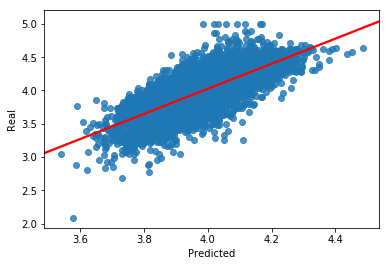

Rating	Below_Average	Average	Above_Average
Below_Average	869	2073	11
Average      	152	3798	92
Above_Average	2	2181	1002


In [45]:
print(Ridge.score(train_lsa, train['book_rating']))

pred = Ridge.predict(train_lsa)
real = train['book_rating']
ax = sns.regplot(x = pred, y = real, line_kws={'color': 'red'})
ax.set(xlabel='Predicted', ylabel='Real')
plt.show()
#This code uses the boundaries defined above to split the data roughly into thirds.
pred = pd.cut(pred,
              bins=[-1, BRLow, BRHigh, 6],
              labels=["Below_Average", "Average", "Above_Average"])

real = pd.cut(real,
              bins=[-1, BRLow, BRHigh, 6],
              labels=["Below_Average", "Average", "Above_Average"])

cm = confusion_matrix(y_true=list(real), 
                 y_pred= list(pred),
                labels=["Below_Average", "Average", "Above_Average"])

print("Rating\tBelow_Average\tAverage\tAbove_Average",
     "Below_Average\t%d\t%d\t%d" % tuple(cm[0]),
     "Average      \t%d\t%d\t%d" % tuple(cm[1]),
     "Above_Average\t%d\t%d\t%d" % tuple(cm[2]),
     sep = "\n")

0.22884786633887955


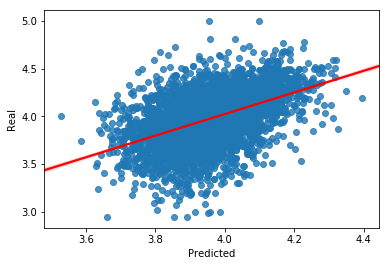

Rating	Below_Average	Average	Above_Average
Below_Average	333	910	15
Average      	218	1363	83
Above_Average	68	1006	368


In [46]:
print(Ridge.score(test_lsa, test['book_rating']))

pred = Ridge.predict(test_lsa)
real = test['book_rating']
ax = sns.regplot(x = pred, y = real, line_kws={'color': 'red'})
ax.set(xlabel='Predicted', ylabel='Real')

plt.show()

pred = pd.cut(pred,
              bins=[-1, BRLow, BRHigh, 6],
              labels=["Below_Average", "Average", "Above_Average"])

real = pd.cut(real,
              bins=[-1, BRLow, BRHigh, 6],
              labels=["Below_Average", "Average", "Above_Average"])
cm = confusion_matrix(y_true=list(real), 
                 y_pred= list(pred),
                labels=["Below_Average", "Average", "Above_Average"])

print("Rating\tBelow_Average\tAverage\tAbove_Average",
     "Below_Average\t%d\t%d\t%d" % tuple(cm[0]),
     "Average      \t%d\t%d\t%d" % tuple(cm[1]),
     "Above_Average\t%d\t%d\t%d" % tuple(cm[2]),
     sep = "\n")

In [47]:
from sklearn.linear_model import Lasso
Lasso = Lasso(alpha=.012)
Lasso.fit(train_lsa, train['book_rating'])

Lasso(alpha=0.012, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

0.01938346489495868


C:\Users\Ebel\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


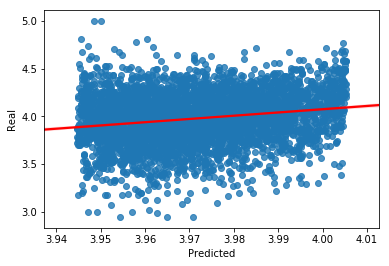

Rating	Below_Average	Average	Above_Average
Below_Average	333	910	15
Average      	218	1363	83
Above_Average	68	1006	368


In [48]:
print(Lasso.score(test_lsa, test['book_rating']))

pred = Lasso.predict(test_lsa)
real = test['book_rating']
ax = sns.regplot(x = pred, y = real, line_kws={'color': 'red'})
ax.set(xlabel='Predicted', ylabel='Real')
plt.show()

pred = pd.cut(pred,
              bins=[-1, BRLow, BRHigh, 6],
              labels=["Below_Average", "Average", "Above_Average"])

real = pd.cut(real,
              bins=[-1, BRLow, BRHigh, 6],
              labels=["Below_Average", "Average", "Above_Average"])

print("Rating\tBelow_Average\tAverage\tAbove_Average",
     "Below_Average\t%d\t%d\t%d" % tuple(cm[0]),
     "Average      \t%d\t%d\t%d" % tuple(cm[1]),
     "Above_Average\t%d\t%d\t%d" % tuple(cm[2]),
     sep = "\n")

It seems, in linear regression, that ridge regression preforms better than lasso regression with this data set. The LSA eliminated much of the noise in the data set, and this regression may be dropping too many features by bringing their correlations down to 0. Both of these regressions tweaked in term of alpha and the hyperparameter configuration in this notebook is the configuration that returned maximum accuracy on the training set.  

<a name="TropeID"></a>
## Trope Identification 

One of the benefits of regression is the ability to break down one particular components had the most impact on the models prediction. Earlier, the vectors were broken down and combined together using LSA. This combined vectors into similar and often correlated values, indicating that such words were often found together in the data. The regressions each then took these components, and then assigned coefficients which dictated the prediction that they would make. The following code comes in two parts, one is the sorting of SVD components by the impact they had on each regression. The other is the enumeration of the original values that were in that SVD component. 

In [49]:
print("Lasso coefficients:\n", np.append(Lasso.intercept_, Lasso.coef_),
     "\n\nRidge coefficients:\n", np.append(Ridge.intercept_, Ridge.coef_))

Lasso coefficients:
 [ 3.97365871  0.0316904  -0.         ...  0.          0.
 -0.        ] 

Ridge coefficients:
 [ 4.03644634  0.09692776 -0.58738999 ...  0.01106516  0.00669468
 -0.0067729 ]


In [50]:
# for lasso
# get component with highest influence on the model
lasso_components = Lasso.coef_
lasso_max = np.abs(lasso_components)
lasso_max = lasso_max[lasso_max != 0]
lasso_max =np.sort(lasso_max)[::-1]
lasso_max = lasso_max[:3] # get the max only

lasso_components = [idx[0] for m in lasso_max for idx in np.where(np.abs(lasso_components) == m)]

features_by_component=pd.DataFrame(svd.components_,columns=TfIdf.get_feature_names())
for i in lasso_components:
    print('Component {}:'.format(i))
    print(features_by_component.loc[i,:].sort_values(ascending=False)[0:5])
    print()

Component 0:
00          0.999897
novels      0.002243
internet    0.001606
bet         0.001602
world       0.001587
Name: 0, dtype: float64



As suspected, many of the coefficients are being set to 0 in the lass regression. Only one feature was being considered. 

In [51]:
# for ridge regression
# get component with highest influence on the model
ridge_components = Ridge.coef_
ridge_max = np.abs(ridge_components)
ridge_max = ridge_max[ridge_max != 0]
ridge_max =np.sort(ridge_max)[::-1]
ridge_max = ridge_max[:3] # get the max only

ridge_components = [idx[0] for m in ridge_max for idx in np.where(np.abs(ridge_components) == m)]

features_by_component=pd.DataFrame(svd.components_,columns=TfIdf.get_feature_names())
for i in ridge_components:
    print('Component {}:'.format(i))
    print(features_by_component.loc[i,:].sort_values(ascending=False)[0:5])
    print()

Component 9:
bookclub    0.356304
magic       0.186861
series      0.173376
holmes      0.149749
sherlock    0.106967
Name: 9, dtype: float64

Component 6:
new       0.338461
york      0.233310
killer    0.155058
times     0.154062
bet       0.145557
Name: 6, dtype: float64

Component 3:
vampire     0.270408
bookclub    0.198388
world       0.193664
series      0.162230
human       0.123022
Name: 3, dtype: float64



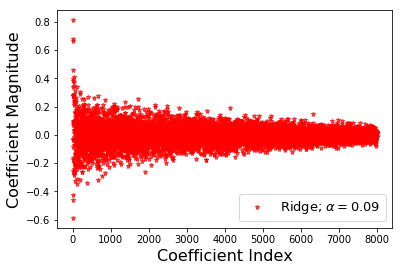

In [52]:
plt.plot(Ridge.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.09$',zorder=7) # zorder for ordering the markers

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=4)
plt.show()

In [53]:

#These categories were built to be reasonably sized and rationally premised.
train['Rating_Value'] =  pd.cut(BR, bins=[-1, (BR.mean()- (BRs)), (BR.mean()+ (BRs)), 6], 
                             labels=np.array('Below_Average Average Above_Average'.split()))
test['Rating_Value'] =  pd.cut(BR, bins=[-1, (BR.mean()- (BRs)), (BR.mean()+ (BRs)), 6], 
                             labels=np.array('Below_Average Average Above_Average'.split()))
# labels = np.array('White Yellow Amber Red'.split())

In [54]:
test['Rating_Value'].value_counts()

Average          1746
Above_Average    1666
Below_Average     952
Name: Rating_Value, dtype: int64

In [55]:

#Finding the dominant class
1746/len(test)

0.4000916590284143

<a name="NN"></a>

## Application of Neural Networks

A multilayer perceptron model is a relatively simple network to employ here. The multilayer perceptron takes inputs of data, and attempts to classify it according to sets of patterns it spots. In essence it splits and categorizes data into categories it decides are important in predicting an output variable, finding patterns that were previously undefined by the data. This can be used for regression or classification, as the model can predict specific values from different combinations of categories. 

This is a second step to find larger themes to use for prediction. The hyperparameters were initially picked based on some similar models employed in NLP, and tweaked and experimented with. However the regression preformed actively worse than random guessing, and the classifier could not predict a greater proportion of the data than the dominant class.

In [56]:
from sklearn.neural_network import MLPRegressor
MLPR = MLPRegressor(hidden_layer_sizes =(1000, 2),
                          learning_rate_init=0.001,
                           batch_size='auto', momentum = .7)
MLPR.fit(train_lsa, train['book_rating'])

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.7,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [57]:
MLPR.score(test_lsa, test['book_rating'])

-0.5951516117944737

C:\Users\Ebel\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


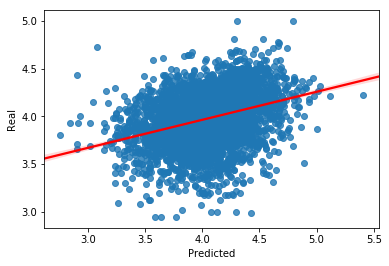

In [58]:
pred = MLPR.predict(test_lsa)
real = test['book_rating']
pred
ax = sns.regplot(x = pred, y = real, line_kws={'color': 'red'})
ax.set(xlabel='Predicted', ylabel='Real')
plt.show()

In [59]:
from sklearn.neural_network import MLPClassifier

MLPC = MLPClassifier(hidden_layer_sizes=(2000,), activation='relu', solver='adam', alpha=0.01, 
                    batch_size='auto', learning_rate='constant', learning_rate_init=0.001, 
                    max_iter=200,
                    momentum=0.5)
MLPC.fit(train_lsa, train['Rating_Value'])



MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(2000,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.5,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [60]:
MLPC.score(test_lsa, test['Rating_Value'])

0.34417965169569203

In [61]:
confusion_matrix(y_true=test['Rating_Value'], 
                 y_pred= MLPC.predict(test_lsa),
                labels= ['Below_Average', 'Average', 'Above_Average'])

array([[273, 394, 285],
       [475, 681, 590],
       [442, 676, 548]], dtype=int64)

<a name="RF"></a>
## Application of Random Forest Models
A random forest is an ensemble model in which a large array of forests are generated around features and make splits in the data based on those features in order to make predictions, in which a decision tree is formed around the most valuable features and used to predict an output value. A large number of these trees and their decisions on a particular data point are counted and summed, and the majority decision by the decision trees dictates the value.

In [62]:
from sklearn.ensemble import RandomForestRegressor
#Note that n_jobs should be altered to the users personal computer and preference. 
RFR = RandomForestRegressor(n_estimators=100, max_features=3000, n_jobs=6)
RFR.fit(train_lsa, train['book_rating'])

C:\Users\Ebel\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=3000, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [63]:
RFR.score(test_lsa, test['book_rating'])

0.1419207770506905

That's substantially worse than ridge regression. 

In [64]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(n_estimators=1000, n_jobs=8)
RFC.fit(train_lsa, train['Rating_Value'])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [65]:
RFC.score(test_lsa, test['Rating_Value'])

0.38955087076076994

In [66]:
confusion_matrix(y_true=test['Rating_Value'], 
                 y_pred= RFC.predict(test_lsa),
                labels= ['Below_Average', 'Average', 'Above_Average'])

array([[  11,  809,  132],
       [  37, 1475,  234],
       [  31, 1421,  214]], dtype=int64)

Better than the multilayer perceptron. 

<a name="conclusion"></a>
## Conclusion
The best performance on regression was with ridge regression, the best performance for classification was the random forest classifier. However, Classification never preformed higher than the dominant class in the test data. Ultimately, the best performance on a regression was a .23 R2 score from the ridge regression. Only mildly better than random guessing.

Evaluating a book from it's cover is, as the saying implies, difficult. While the models developed here can do better than random guessing, and could be used by a particularly desperate author or analyst, there's plenty of room for improvement. 

The most promising methodology employed here, both in terms of actionable results, and in terms of theoretical potential, would be the use of a neural network to pull out patterns in the large amounts of features produced by the vectorization. 

In particular being able to tweak the neural network to pull on specific "tropes" has the potential increase model accuracy and identify particular values of any trope. 

Finally, the addition of less popular books will help the model get a greater variety of works, and help make it more versatile. Also, it is possible that less popular books are less unique, making them easier to pick apart as being similar to one another in quality. 

Overall, this is a project that needs to be reviewed and re-evaluated, it may never be easy to presume the value of a book without reading it, but it can be attempted, with more advanced methodologies than what's featured here. 